# Sprint 6 - Predicting future environmental intensity (Time Series) and Collect Companies Descriptions

In this notebook, we will predict future environmental intensity for all the companies in the 'Excel data'. We will be using data from previous years to predict the future environmental intesity. 

First, we will create the following columns:

1) Industry Indicator
- 1 if above the industry average in current year
- 0 if at industry average in current yeat
- (-1) if below the industry average in current year
2) Environmental Intensity Growth : ((Environmental Intensity in Current Year / Environmental Intensity Last Year) - 1) * 100


At the end, we collected, directly from Yahoo Finance website, each company description. For this, we use the pilot stocks which have the Ticker identifier. 

In [197]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import warnings
from sklearn import linear_model
from sklearn import metrics
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import requests
from bs4 import BeautifulSoup
warnings.filterwarnings('ignore')

In [198]:
df = pd.read_csv('Environmental_Impact_dataset.csv')
column_list = []
for column in df.columns:
    column_list.append(column.replace(' ', ''))
df.columns = column_list
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns')
df.head(3)

The dataset has 14515 rows and 11 columns


,Year,CompanyName,Country,Industry(Exiobase),EnvironmentalIntensity(Sales),Env_intensity,industry_avg,Industry_indicator,industry_avg_year,Industry_indicator_year,Environmental_Growth
0,2016,1&1 DRILLISCH AG,Germany,Post and telecommunications (64),-0.07%,-0.0007,-0.018382,1,-0.011640,1,NaN
1,2010,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.12%,-0.0012,-0.020072,1,-0.006402,1,NaN
2,2011,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.16%,-0.0016,-0.020072,1,-0.009838,1,33.333333


In [199]:
df = df.iloc[:,0:6]
df.head()

,Year,CompanyName,Country,Industry(Exiobase),EnvironmentalIntensity(Sales),Env_intensity
0,2016,1&1 DRILLISCH AG,Germany,Post and telecommunications (64),-0.07%,-0.0007
1,2010,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.12%,-0.0012
2,2011,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.16%,-0.0016
3,2012,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.15%,-0.0015
4,2010,3M COMPANY,United States,Activities of membership organisation n.e.c. ...,-7.90%,-0.0790


Noticed the company name values have spaces at the beginning and end. We will fix that in the next cells. Also, we will format the environmental intensity to decimals.

In [200]:
companies = df.CompanyName.tolist()
com = []

for c in companies:
    com.append(c.lstrip().rstrip())
    
df['CompanyName'] = com

In [201]:
def percent_to_float(s):
    return float(s.strip('%')) / 100.0

replace_dict = {'(':'',')':'', ' ' : '', ',' : ''}
def paranthesis_to_minus(value):
    for i, j in replace_dict.items():
        value = value.replace(i, j)
    value = int(f'-{value}')
    return value

df['Env_intensity'] = df['EnvironmentalIntensity(Sales)'].apply(percent_to_float)

In [202]:
df.head()

,Year,CompanyName,Country,Industry(Exiobase),EnvironmentalIntensity(Sales),Env_intensity
0,2016,1&1 DRILLISCH AG,Germany,Post and telecommunications (64),-0.07%,-0.0007
1,2010,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.12%,-0.0012
2,2011,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.16%,-0.0016
3,2012,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.15%,-0.0015
4,2010,3M COMPANY,United States,Activities of membership organisation n.e.c. ...,-7.90%,-0.0790


### Creating industry indicator

In [203]:
industry_avg = df.groupby('Industry(Exiobase)')[['Env_intensity']].mean().reset_index()
df['industry_avg'] = df['Env_intensity'].groupby(df['Industry(Exiobase)']).transform('mean')

In [204]:
def create_ind(df):
    if(df['Env_intensity'] > df['industry_avg']):
        return 1
    elif (df['Env_intensity'] == df['industry_avg']):
        return 0
    elif (df['Env_intensity'] < df['industry_avg']):
        return -1

df['Industry_indicator'] = df.apply(create_ind, axis = 1)
df.head()

,Year,CompanyName,Country,Industry(Exiobase),EnvironmentalIntensity(Sales),Env_intensity,industry_avg,Industry_indicator
0,2016,1&1 DRILLISCH AG,Germany,Post and telecommunications (64),-0.07%,-0.0007,-0.018382,1
1,2010,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.12%,-0.0012,-0.020072,1
2,2011,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.16%,-0.0016,-0.020072,1
3,2012,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.15%,-0.0015,-0.020072,1
4,2010,3M COMPANY,United States,Activities of membership organisation n.e.c. ...,-7.90%,-0.0790,-0.117561,1


In [205]:
def create_ind_year(df):
    if(df['Env_intensity'] > df['industry_avg_year']):
        return 1
    elif (df['Env_intensity'] == df['industry_avg_year']):
        return 0
    elif (df['Env_intensity'] < df['industry_avg_year']):
        return -1

df['industry_avg_year'] = df.groupby(['Industry(Exiobase)','Year']).transform('mean')[['Env_intensity']]

df['Industry_indicator_year'] = df.apply(create_ind_year, axis = 1)
df.head()

,Year,CompanyName,Country,Industry(Exiobase),EnvironmentalIntensity(Sales),Env_intensity,industry_avg,Industry_indicator,industry_avg_year,Industry_indicator_year
0,2016,1&1 DRILLISCH AG,Germany,Post and telecommunications (64),-0.07%,-0.0007,-0.018382,1,-0.011640,1
1,2010,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.12%,-0.0012,-0.020072,1,-0.006402,1
2,2011,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.16%,-0.0016,-0.020072,1,-0.009838,1
3,2012,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.15%,-0.0015,-0.020072,1,-0.024437,1
4,2010,3M COMPANY,United States,Activities of membership organisation n.e.c. ...,-7.90%,-0.0790,-0.117561,1,-0.084583,1


In [206]:
df.loc[(df['Industry(Exiobase)'] == 'Activities auxiliary to financial intermediation (67)'),:].sort_values(by='Year')

,Year,CompanyName,Country,Industry(Exiobase),EnvironmentalIntensity(Sales),Env_intensity,industry_avg,Industry_indicator,industry_avg_year,Industry_indicator_year
8166,2016,ADECCO GROUP AG,Switzerland,Activities auxiliary to financial intermediati...,-0.10%,-0.0010,-0.004417,1,-0.007880,1
14368,2016,WOLTERS KLUWER NV,Netherlands,Activities auxiliary to financial intermediati...,-0.20%,-0.0020,-0.004417,1,-0.007880,1
14123,2016,VERISK ANALYTICS INCORPORATION,United States,Activities auxiliary to financial intermediati...,-0.21%,-0.0021,-0.004417,1,-0.007880,1
13738,2016,TELEPERFORMANCE SE,France,Activities auxiliary to financial intermediati...,-1.10%,-0.0110,-0.004417,-1,-0.007880,-1
12891,2016,SAGA PLC,United Kingdom,Activities auxiliary to financial intermediati...,-2.82%,-0.0282,-0.004417,-1,-0.007880,-1
...,...,...,...,...,...,...,...,...,...,...
9736,2019,DKSH HOLDING AG,Switzerland,Activities auxiliary to financial intermediati...,-0.17%,-0.0017,-0.004417,1,0.002943,-1
10721,2019,HONG KONG EXCHANGES AND CLEARING LIMITED,Hong Kong,Activities auxiliary to financial intermediati...,-0.34%,-0.0034,-0.004417,1,0.002943,-1
10077,2019,EXPERIAN PLC,United Kingdom,Activities auxiliary to financial intermediati...,-0.20%,-0.0020,-0.004417,1,0.002943,-1
11536,2019,LONDON STOCK EXCHANGE GROUP PLC,United Kingdom,Activities auxiliary to financial intermediati...,-0.19%,-0.0019,-0.004417,1,0.002943,-1


### Creating Environmental growth

Environmental Intensity Growth : ((Environmental Intensity in Current Year / Environmental Intensity Last Year) - 1) * 100

In [207]:
df = df.sort_values(by=['CompanyName','Year'], ascending = True)
df.head()

,Year,CompanyName,Country,Industry(Exiobase),EnvironmentalIntensity(Sales),Env_intensity,industry_avg,Industry_indicator,industry_avg_year,Industry_indicator_year
0,2016,1&1 DRILLISCH AG,Germany,Post and telecommunications (64),-0.07%,-0.0007,-0.018382,1,-0.011640,1
1,2010,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.12%,-0.0012,-0.020072,1,-0.006402,1
2,2011,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.16%,-0.0016,-0.020072,1,-0.009838,1
3,2012,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.15%,-0.0015,-0.020072,1,-0.024437,1
4,2010,3M COMPANY,United States,Activities of membership organisation n.e.c. ...,-7.90%,-0.0790,-0.117561,1,-0.084583,1


In [208]:
df['Environmental_Growth'] = df.groupby(['CompanyName'])['Env_intensity'].apply(lambda x: x.pct_change()).to_numpy() * 100
df.head()

,Year,CompanyName,Country,Industry(Exiobase),EnvironmentalIntensity(Sales),Env_intensity,industry_avg,Industry_indicator,industry_avg_year,Industry_indicator_year,Environmental_Growth
0,2016,1&1 DRILLISCH AG,Germany,Post and telecommunications (64),-0.07%,-0.0007,-0.018382,1,-0.011640,1,NaN
1,2010,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.12%,-0.0012,-0.020072,1,-0.006402,1,NaN
2,2011,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.16%,-0.0016,-0.020072,1,-0.009838,1,33.333333
3,2012,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.15%,-0.0015,-0.020072,1,-0.024437,1,-6.250000
4,2010,3M COMPANY,United States,Activities of membership organisation n.e.c. ...,-7.90%,-0.0790,-0.117561,1,-0.084583,1,NaN


### Model 1 - Past years Environmental Intensity

In [209]:
df1 = df.copy()

In [210]:
companies_2018 = list(df1[df1['Year'] == 2018]['CompanyName'])
companies_2019 = list(df1[(df1['Year'] == 2019) & (df1['CompanyName'].isin(companies_2018))]['CompanyName'])

#Getting companies that are in both years
list2018_as_set = set(companies_2018)
intersection = list2018_as_set.intersection(companies_2019)

X = df1[(df1['Year'] == 2018) & (df1['CompanyName'].isin(intersection))][['Env_intensity']]
y = df1[(df1['Year'] == 2019) & (df1['CompanyName'].isin(intersection))][['Env_intensity']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)


reg = LinearRegression().fit(X_train, y_train)

y_pred = reg.predict(X_test)

print('R2 score:', metrics.r2_score(y_test, y_pred))
print('MSE: ', metrics.mean_squared_error(y_test, y_pred))


R2 score: 0.8825319170790614
MSE:  0.010786739663931545


### Model 2 - Past years average environmental intensity

In this section, we will use the average environmental intensity of 2016-2018 to predict 2019 environmental intensity

In [211]:
df2 = df.copy()
EI_2016 = df2[df2['Year'] == 2016]
EI_2017 = df2[df2['Year'] == 2017]
EI_2018 = df2[df2['Year'] == 2018]
EI_2019 = df2[df2['Year'] == 2019]

In [212]:
df_mod2 = EI_2016.merge(EI_2017, how='inner', on='CompanyName', suffixes=('_2016', '_2017'))
df_mod2 = df_mod2.merge(EI_2018, how='inner', on='CompanyName')
df_mod2 = df_mod2.merge(EI_2019, how='inner', on='CompanyName', suffixes=('_2018', '_2019'))

In [213]:
df_mod2 = df_mod2[['CompanyName','Year_2016','Env_intensity_2016','Year_2017','Env_intensity_2017','Year_2018','Env_intensity_2018','Year_2019','Env_intensity_2019']]

In [214]:
df_mod2.head()

,CompanyName,Year_2016,Env_intensity_2016,Year_2017,Env_intensity_2017,Year_2018,Env_intensity_2018,Year_2019,Env_intensity_2019
0,3M COMPANY,2016,-0.0705,2017,-0.0660,2018,-0.0710,2019,-0.0641
1,A.G.V. PRODUCTS CORP,2016,-0.0170,2017,-0.0190,2018,-0.0140,2019,-0.0172
2,AA PLC,2016,-0.0130,2017,-0.0124,2018,-0.0117,2019,-0.0070
3,AAC TECHNOLOGIES HOLDINGS INCORPORATION,2016,-0.0389,2017,-0.0591,2018,-0.0802,2019,-0.1080
4,AAREAL BANK AG,2016,-0.0024,2017,-0.0021,2018,-0.0019,2019,-0.0015


In [215]:
df_melt2 = pd.melt(df_mod2, id_vars=['CompanyName'], value_vars=['Env_intensity_2016','Env_intensity_2016','Env_intensity_2017'],
        var_name='myVarname', value_name='Environmental_intenrsity')

In [216]:
df_melt2.head()

,CompanyName,myVarname,Environmental_intenrsity
0,3M COMPANY,Env_intensity_2016,-0.0705
1,A.G.V. PRODUCTS CORP,Env_intensity_2016,-0.0170
2,AA PLC,Env_intensity_2016,-0.0130
3,AAC TECHNOLOGIES HOLDINGS INCORPORATION,Env_intensity_2016,-0.0389
4,AAREAL BANK AG,Env_intensity_2016,-0.0024


In [217]:
ei_avg = df_melt2.groupby('CompanyName').mean().reset_index()
X = ei_avg[['Environmental_intenrsity']]
y = df_mod2[['Env_intensity_2019']]

print(X.shape)
print(y.shape)

(1065, 1)
(1065, 1)


In [218]:
x_train, x_test, y_train, y_test = train_test_split(X ,y, test_size = 0.2, random_state = 42)
# train Linear Regression
LRtrainer = LinearRegression()
LRtrainer.fit(x_train,y_train)

# mse for linear regression
y_pred_lr = LRtrainer.predict(x_test)
print(metrics.mean_squared_error(y_pred_lr, y_test))

0.006269966737857913


In [219]:
# display the parameters
print('Model intercept: ', LRtrainer.intercept_)
print('Model coefficients: ', LRtrainer.coef_)

Model intercept:  [-0.0051724]
Model coefficients:  [[0.80432622]]


In [220]:
print('R2 score:', metrics.r2_score(y_test, y_pred_lr))

R2 score: 0.8756921251462437


### Model 3 - Yearly Industry Average

For this model, the predictor will be the industry average for the respective year. 
There is no data for 2020, so we plan to predict 2019 environmental intensity.  Accordingly, we used 2018 and 2017 Industry data (past data) to predict 2019 evronmental intensity. 

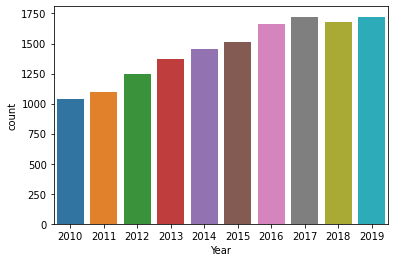

In [221]:
sns.countplot(x='Year', data = df)

The dataset does not contain consistent records throught out the years. Therefore, it could be possible we have data for one company in 2019 but not data from that company in 2018, 2017, etc. 

We will start by only using 2018 industry average as a feature to predict 2019 environmental intensity. First, we will subset the companies that we have 2018 data and get their 2019 environmental intensity.

In [222]:
df_2018 = df.loc[df.Year == 2018, ]
df_2019 = df.loc[df.Year == 2019, ]
df_mod3 = pd.merge(df_2018, df_2019, on='CompanyName',how='inner')
df_mod3 = df_mod3[['Year_x','CompanyName','industry_avg_year_x','Year_y','Env_intensity_y']]
df_mod3.head()

,Year_x,CompanyName,industry_avg_year_x,Year_y,Env_intensity_y
0,2018,3M COMPANY,-0.229308,2019,-0.0641
1,2018,3SBIO INC,-0.027793,2019,-0.0340
2,2018,A.G.V. PRODUCTS CORP,-0.072254,2019,-0.0172
3,2018,AA PLC,-0.073777,2019,-0.0070
4,2018,AAC TECHNOLOGIES HOLDINGS INCORPORATION,-0.023555,2019,-0.1080


In [223]:
X = df_mod3[['industry_avg_year_x']]
y = df_mod3.iloc[:,4]
print(X.shape)
print(y.shape)

(1336, 1)
(1336,)


In [224]:
x_train, x_test, y_train, y_test = train_test_split(X ,y, test_size = 0.2, random_state = 42)
# train Linear Regression
LRtrainer = LinearRegression()
LRtrainer.fit(x_train,y_train)

# mse for linear regression
y_pred_lr = LRtrainer.predict(x_test)
print(metrics.mean_squared_error(y_pred_lr, y_test))

0.06598743409385226


In [225]:
# display the parameters
print('Model intercept: ', LRtrainer.intercept_)
print('Model coefficients: ', LRtrainer.coef_)

Model intercept:  0.0002669631900767411
Model coefficients:  [0.91303819]


In [226]:
print('R2 score:', metrics.r2_score(y_test, y_pred_lr))

R2 score: 0.36647102462935643


Now, we are going to consider 2017 - 2018 to predict 2019

In [227]:
df_2019=df[df['Year'] == 2019]
df_2018=df[df['Year'] == 2018]
df_2017=df[df['Year'] == 2017]

In [228]:
df2019=df_2019[['Year','CompanyName','Env_intensity']] 
df2019.rename(columns={'Env_intensity': 'Env_intensity2019'}, inplace=True) 
df2018=df_2018[['CompanyName','industry_avg_year']]
df2018.rename(columns={'industry_avg_year': 'Ind_Yearavg2018'}, inplace=True) 
df2017=df_2017[['CompanyName','industry_avg_year']]
df2017.rename(columns={'industry_avg_year': 'Ind_Yearavg2017'}, inplace=True) 
mdl = pd.merge(df2019, df2018, on=["CompanyName"])
mdl1= pd.merge(mdl, df2017, on=["CompanyName"])
mdl1

,Year,CompanyName,Env_intensity2019,Ind_Yearavg2018,Ind_Yearavg2017
0,2019,3M COMPANY,-0.0641,-0.229308,-0.225496
1,2019,3SBIO INC,-0.0340,-0.027793,-0.031771
2,2019,A.G.V. PRODUCTS CORP,-0.0172,-0.072254,-0.063618
3,2019,AA PLC,-0.0070,-0.073777,-0.096157
4,2019,AAC TECHNOLOGIES HOLDINGS INCORPORATION,-0.1080,-0.023555,-0.027254
...,...,...,...,...,...
1190,2019,ZEON CORPORATION,-0.0730,-0.218707,-0.275385
1191,2019,ZHEN DING TECHNOLOGY HOLDING LIMITED,-0.0602,-0.076812,-0.068294
1192,2019,ZIG SHENG INDUSTRIAL COMPANY LIMITED,-0.1615,-0.124750,-0.117456
1193,2019,ZORLU ENERJI AS,-0.3430,-1.012140,-0.578986


In [229]:
X=mdl1[['Ind_Yearavg2018','Ind_Yearavg2017']]
y=mdl1['Env_intensity2019']
print(X.shape)
print(y.shape)

(1195, 2)
(1195,)


In [230]:
regr = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
regr.fit(X_train, y_train)
y_train_pred = np.exp(regr.predict(X_train))
y_pred = np.exp(regr.predict(X_test))
y_test = np.exp(y_test)

In [231]:
print('MSE train: %.3f, test: %.3f' % (metrics.mean_squared_error(y_train, y_train_pred),
                metrics.mean_squared_error(y_test, y_pred)))

MSE train: 1.064, test: 0.038


In [232]:
# display the parameters
print('Model intercept: ', regr.intercept_)
print('Model coefficients: ', regr.coef_)

Model intercept:  0.000576398328011471
Model coefficients:  [ 0.94555899 -0.06948928]


In [233]:
print('R2 score:', metrics.r2_score(y_test, y_pred))

R2 score: 0.26873239153605155


Using the industry environmental average for 2017 and 2018 only explained 27% of the variation in the dataset. Let's see what happens including 2016-2018 to predict 2019

In [234]:
df_2016 = df.loc[df.Year == 2016, ]
df_2017 = df.loc[df.Year == 2017, ]
df1 = df_2016.merge(df_2017, how='inner', on='CompanyName', suffixes=('_2016', '_2017'))
df1 = df1.merge(df_2018, how='inner', on='CompanyName')
df1 = df1.merge(df_2019, how='inner', on='CompanyName', suffixes=('_2018', '_2019'))
df1 = df1[['Year_2016','industry_avg_year_2016','Year_2017','industry_avg_year_2017','Year_2018','industry_avg_year_2018','Year_2019','Env_intensity_2019']]

In [235]:
X = df1[['industry_avg_year_2016','industry_avg_year_2017','industry_avg_year_2018']]
y = df1.iloc[:,7]
print(X.shape)
print(y.shape)

(1065, 3)
(1065,)


In [236]:
regr = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
regr.fit(X_train, y_train)
y_train_pred = regr.predict(X_train)
y_pred = regr.predict(X_test)

In [237]:
print('MSE train: %.3f, test: %.3f' % (metrics.mean_squared_error(y_train, y_train_pred),
                metrics.mean_squared_error(y_test, y_pred)))

MSE train: 0.033, test: 0.031


In [238]:
# display the parameters
print('Model intercept: ', regr.intercept_)
print('Model coefficients: ', regr.coef_)

Model intercept:  0.0030480783209566598
Model coefficients:  [0.30694139 0.28498824 0.26816881]


In [239]:
print('R2 score:', metrics.r2_score(y_test, y_pred))

R2 score: 0.39520621546916435


### Model 4 -Yearly Industry Indicator

For this model, we will consider the yearly industry indicator from past years to predict the company 2019 environmental intensity. 

We are going to start from 2017-2018 to predict 2019. 

In [240]:
df_2019=df[df['Year'] == 2019]
df_2018=df[df['Year'] == 2018]
df_2017=df[df['Year'] == 2017]

df2019=df_2019[['Year','CompanyName','Env_intensity']] 
df2019.rename(columns={'Env_intensity': 'Env_intensity2019'}, inplace=True) 
df2018=df_2018[['CompanyName','Industry_indicator_year']]
df2018.rename(columns={'Industry_indicator_year': 'Ind_Indicator_2018'}, inplace=True) 
df2017=df_2017[['CompanyName','Industry_indicator_year']]
df2017.rename(columns={'Industry_indicator_year': 'Ind_Indicator_2017'}, inplace=True) 
mdl4 = pd.merge(df2019, df2018, on=["CompanyName"])
mdl4= pd.merge(mdl4, df2017, on=["CompanyName"])
mdl4

,Year,CompanyName,Env_intensity2019,Ind_Indicator_2018,Ind_Indicator_2017
0,2019,3M COMPANY,-0.0641,1,1
1,2019,3SBIO INC,-0.0340,-1,1
2,2019,A.G.V. PRODUCTS CORP,-0.0172,1,1
3,2019,AA PLC,-0.0070,1,1
4,2019,AAC TECHNOLOGIES HOLDINGS INCORPORATION,-0.1080,-1,-1
...,...,...,...,...,...
1190,2019,ZEON CORPORATION,-0.0730,1,1
1191,2019,ZHEN DING TECHNOLOGY HOLDING LIMITED,-0.0602,1,1
1192,2019,ZIG SHENG INDUSTRIAL COMPANY LIMITED,-0.1615,-1,-1
1193,2019,ZORLU ENERJI AS,-0.3430,1,1


In [241]:
X=mdl4[['Ind_Indicator_2017','Ind_Indicator_2018']]
y=mdl4['Env_intensity2019']
print(X.shape)
print(y.shape)

(1195, 2)
(1195,)


In [242]:
regr = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
regr.fit(X_train, y_train)
y_train_pred = regr.predict(X_train)
y_pred = regr.predict(X_test)

In [243]:
print('MSE train: %.3f, test: %.3f' % (metrics.mean_squared_error(y_train, y_train_pred),
                metrics.mean_squared_error(y_test, y_pred)))

MSE train: 0.048, test: 0.062


In [244]:
# display the parameters
print('Model intercept: ', regr.intercept_)
print('Model coefficients: ', regr.coef_)

Model intercept:  -0.1535641068337678
Model coefficients:  [0.03709691 0.07830873]


In [245]:
print('R2 score:', metrics.r2_score(y_test, y_pred))

R2 score: 0.21186363020947363


The industry indicator isn't a good predictor for environmental intensity. 

Let's try including 2016-2018 to predict 2019 environmental intensity. 

In [246]:
df_2016=df[df['Year'] == 2016]
df2016=df_2016[['CompanyName','Industry_indicator_year']]
df2016.rename(columns={'Industry_indicator_year': 'Ind_Indicator_2016'}, inplace=True) 

mdl4 = pd.merge(df2019, df2018, on=["CompanyName"])
mdl4= pd.merge(mdl4, df2017, on=["CompanyName"])
mdl4= pd.merge(mdl4, df2016, on=["CompanyName"])
mdl4.head()

,Year,CompanyName,Env_intensity2019,Ind_Indicator_2018,Ind_Indicator_2017,Ind_Indicator_2016
0,2019,3M COMPANY,-0.0641,1,1,1
1,2019,A.G.V. PRODUCTS CORP,-0.0172,1,1,1
2,2019,AA PLC,-0.0070,1,1,1
3,2019,AAC TECHNOLOGIES HOLDINGS INCORPORATION,-0.1080,-1,-1,-1
4,2019,AAREAL BANK AG,-0.0015,1,1,1


In [247]:
X = mdl4[['Ind_Indicator_2016','Ind_Indicator_2017','Ind_Indicator_2018']]
y = mdl4['Env_intensity2019']
print(X.shape)
print(y.shape)

(1065, 3)
(1065,)


In [248]:
regr = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
regr.fit(X_train, y_train)
y_train_pred = regr.predict(X_train)
y_pred = regr.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (metrics.mean_squared_error(y_train, y_train_pred),
                metrics.mean_squared_error(y_test, y_pred)))

MSE train: 0.047, test: 0.039


In [249]:
# display the parameters
print('Model intercept: ', regr.intercept_)
print('Model coefficients: ', regr.coef_)

Model intercept:  -0.14994928238099783
Model coefficients:  [0.01093564 0.02429224 0.07880817]


In [250]:
print('R2 score:', metrics.r2_score(y_test, y_pred))

R2 score: 0.22649691904576263


### Model 5 -Growth Rate

For this model, we will consider the growth rate from past years to predict the company 2019 environmental intensity.

We are going to start from 2017-2018 to predict 2019.

In [251]:
df_2019=df[df['Year'] == 2019]
df_2018=df[df['Year'] == 2018]
df_2017=df[df['Year'] == 2017]

df2019=df_2019[['Year','CompanyName','Env_intensity']] 
df2019.rename(columns={'Env_intensity': 'Env_intensity2019'}, inplace=True) 
df2018=df_2018[['CompanyName','Environmental_Growth']]
df2018.rename(columns={'Environmental_Growth': 'Environmental_Growth_2018'}, inplace=True) 
df2017=df_2017[['CompanyName','Environmental_Growth']]
df2017.rename(columns={'Environmental_Growth': 'Environmental_Growth_2017'}, inplace=True) 
mdl5 = pd.merge(df2019, df2018, on=["CompanyName"])
mdl5= pd.merge(mdl5, df2017, on=["CompanyName"])
mdl5

,Year,CompanyName,Env_intensity2019,Environmental_Growth_2018,Environmental_Growth_2017
0,2019,3M COMPANY,-0.0641,7.575758,-6.382979
1,2019,3SBIO INC,-0.0340,50.672646,NaN
2,2019,A.G.V. PRODUCTS CORP,-0.0172,-26.315789,11.764706
3,2019,AA PLC,-0.0070,-5.645161,-4.615385
4,2019,AAC TECHNOLOGIES HOLDINGS INCORPORATION,-0.1080,35.702200,51.928021
...,...,...,...,...,...
1190,2019,ZEON CORPORATION,-0.0730,-1.272265,-10.273973
1191,2019,ZHEN DING TECHNOLOGY HOLDING LIMITED,-0.0602,1.990050,-30.927835
1192,2019,ZIG SHENG INDUSTRIAL COMPANY LIMITED,-0.1615,-4.232425,-20.251716
1193,2019,ZORLU ENERJI AS,-0.3430,48.046057,-81.144737


In [252]:
mdl5.dropna(inplace = True)#delete rows with missing values
mdl5.shape

(1094, 5)

In [253]:
X=mdl5[['Environmental_Growth_2017','Environmental_Growth_2018']]
y=mdl5['Env_intensity2019']
print(X.shape)
print(y.shape)

(1094, 2)
(1094,)


In [254]:
regr = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
regr.fit(X_train, y_train)
y_train_pred = regr.predict(X_train)
y_pred = regr.predict(X_test)

In [255]:
print('MSE train: %.3f, test: %.3f' % (metrics.mean_squared_error(y_train, y_train_pred),
                metrics.mean_squared_error(y_test, y_pred)))

MSE train: 0.053, test: 0.083


In [256]:
# display the parameters
print('Model intercept: ', regr.intercept_)
print('Model coefficients: ', regr.coef_)

Model intercept:  -0.10344845492642088
Model coefficients:  [-1.28035334e-04 -8.51885195e-05]


In [257]:
print('R2 score:', metrics.r2_score(y_test, y_pred))

R2 score: 0.015827756484296907


The growth rate isn't a good predictor for environmental intensity. Let's try including 2016-2018 to predict 2019 environmental intensity.

In [258]:
df_2016=df[df['Year'] == 2016]
df_2016.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666 entries, 0 to 14508
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Year                           1666 non-null   int64  
 1   CompanyName                    1666 non-null   object 
 2   Country                        1666 non-null   object 
 3   Industry(Exiobase)             1666 non-null   object 
 4   EnvironmentalIntensity(Sales)  1666 non-null   object 
 5   Env_intensity                  1666 non-null   float64
 6   industry_avg                   1666 non-null   float64
 7   Industry_indicator             1666 non-null   int64  
 8   industry_avg_year              1666 non-null   float64
 9   Industry_indicator_year        1666 non-null   int64  
 10  Environmental_Growth           1534 non-null   float64
dtypes: float64(4), int64(3), object(4)
memory usage: 156.2+ KB


In [259]:
df_2016=df[df['Year'] == 2016]
df2016=df_2016[['CompanyName','Environmental_Growth']]
df2016.rename(columns={'Environmental_Growth': 'Environmental_Growth_2016'}, inplace=True) 

mdl5 = pd.merge(df2016, df2017, on=["CompanyName"])
mdl5= pd.merge(mdl5, df2018, on=["CompanyName"])
mdl5= pd.merge(mdl5, df2019, on=["CompanyName"])
mdl5.head()

,CompanyName,Environmental_Growth_2016,Environmental_Growth_2017,Environmental_Growth_2018,Year,Env_intensity2019
0,3M COMPANY,8.964451,-6.382979,7.575758,2019,-0.0641
1,A.G.V. PRODUCTS CORP,-13.265306,11.764706,-26.315789,2019,-0.0172
2,AA PLC,41.304348,-4.615385,-5.645161,2019,-0.0070
3,AAC TECHNOLOGIES HOLDINGS INCORPORATION,-7.159905,51.928021,35.702200,2019,-0.1080
4,AAREAL BANK AG,9.090909,-12.500000,-9.523810,2019,-0.0015


In [260]:
X=mdl5[['Environmental_Growth_2017','Environmental_Growth_2017','Environmental_Growth_2018']]
y=mdl5['Env_intensity2019']
print(X.shape)
print(y.shape)

(1065, 3)
(1065,)


In [261]:
regr = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
regr.fit(X_train, y_train)
y_train_pred = regr.predict(X_train)
y_pred = regr.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (metrics.mean_squared_error(y_train, y_train_pred),
                metrics.mean_squared_error(y_test, y_pred)))

MSE train: 0.054, test: 0.051


In [262]:
# display the parameters
print('Model intercept: ', regr.intercept_)
print('Model coefficients: ', regr.coef_)

Model intercept:  -0.10313988509769206
Model coefficients:  [-7.52619653e-05 -7.52619653e-05 -1.99679709e-04]


In [263]:
print('R2 score:', metrics.r2_score(y_test, y_pred))

R2 score: -0.015590689373768285


Again, we see that each coefficient is negative which could be interpret that an increase in environmental growth decreases the environmental intensity for 2019. R1 score is also negative (is worse that a horizontal line) which mean we can discard this regression.

### Model 6 - Growth Rate(Long Term Trend)

For this model, we will consider the long-term trend from 2015 to 2018 to predict the company 2019 environmental intensity.

### Creating long-term Environmental growth from 2015 to 2018

Long Term Environmental Intensity Growth : (Environmental Intensity in 2018/ Environmental Intensity in 2015 - 1) * 100

In [264]:
df_2015=df[df['Year'] == 2015]
df_2018=df[df['Year'] == 2018]
df_2019=df[df['Year'] == 2019]
df2019=df_2019[['Year','CompanyName','Env_intensity']] 
df2019.rename(columns={'Env_intensity': 'Env_intensity2019'}, inplace=True) 
df2018=df_2018[['CompanyName','Env_intensity']]
df2018.rename(columns={'Env_intensity': 'Env_intensity_2018'}, inplace=True) 
df2015=df_2015[['CompanyName','Env_intensity']]
df2015.rename(columns={'Env_intensity': 'Env_intensity_2015'}, inplace=True) 
mdl6 = pd.merge(df2019, df2018, on=["CompanyName"])
mdl6= pd.merge(mdl6, df2015, on=["CompanyName"])
mdl6

,Year,CompanyName,Env_intensity2019,Env_intensity_2018,Env_intensity_2015
0,2019,3M COMPANY,-0.0641,-0.0710,-0.0647
1,2019,A.G.V. PRODUCTS CORP,-0.0172,-0.0140,-0.0196
2,2019,AA PLC,-0.0070,-0.0117,-0.0092
3,2019,AAC TECHNOLOGIES HOLDINGS INCORPORATION,-0.1080,-0.0802,-0.0419
4,2019,AAREAL BANK AG,-0.0015,-0.0019,-0.0022
...,...,...,...,...,...
979,2019,YTL POWER INTERNATIONAL BERHAD,-1.2311,-1.3485,-1.2496
980,2019,"YUM! BRANDS, INC.",-0.0097,-0.0117,-0.0738
981,2019,ZEON CORPORATION,-0.0730,-0.0776,-0.0822
982,2019,ZHEN DING TECHNOLOGY HOLDING LIMITED,-0.0602,-0.0615,-0.0927


In [265]:
mdl6['long-term trend from 2015 to 2018']=mdl6['Env_intensity_2018']/mdl6['Env_intensity_2015']-1
mdl6.head()

,Year,CompanyName,Env_intensity2019,Env_intensity_2018,Env_intensity_2015,long-term trend from 2015 to 2018
0,2019,3M COMPANY,-0.0641,-0.0710,-0.0647,0.097372
1,2019,A.G.V. PRODUCTS CORP,-0.0172,-0.0140,-0.0196,-0.285714
2,2019,AA PLC,-0.0070,-0.0117,-0.0092,0.271739
3,2019,AAC TECHNOLOGIES HOLDINGS INCORPORATION,-0.1080,-0.0802,-0.0419,0.914081
4,2019,AAREAL BANK AG,-0.0015,-0.0019,-0.0022,-0.136364


After creating the increase rate from 2015 to 2018, we build up the following model.

In [266]:
mdl6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 0 to 983
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Year                               984 non-null    int64  
 1   CompanyName                        984 non-null    object 
 2   Env_intensity2019                  984 non-null    float64
 3   Env_intensity_2018                 984 non-null    float64
 4   Env_intensity_2015                 984 non-null    float64
 5   long-term trend from 2015 to 2018  984 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 53.8+ KB


In [267]:
X=mdl6[['long-term trend from 2015 to 2018']]
y=mdl6['Env_intensity2019']
print(X.shape)
print(y.shape)

(984, 1)
(984,)


In [268]:
regr = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
regr.fit(X_train, y_train)
y_train_pred = regr.predict(X_train)
y_pred = regr.predict(X_test)

In [269]:
print('MSE train: %.3f, test: %.3f' % (metrics.mean_squared_error(y_train, y_train_pred),
                metrics.mean_squared_error(y_test, y_pred)))

MSE train: 0.041, test: 0.090


In [270]:
print('RMSE train:%.3f'% sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
print('RMSE test:%.3f'% sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMSE train:0.204
RMSE test:0.300


In [271]:
# display the parameters
print('Model intercept: ', regr.intercept_)
print('Model coefficients: ', regr.coef_)

Model intercept:  -0.09593328461923026
Model coefficients:  [-0.00498984]


In [272]:
print('R2 score:', metrics.r2_score(y_test, y_pred))

R2 score: -0.0271286829470907


The long-term trend from 2015 to 2018 isn't a good predictor for environmental intensity that R2 score is negative. Let's try including 2010-2014 to predict 2019 environmental intensity.

In [273]:
df_2010=df[df['Year'] == 2010]
df_2014=df[df['Year'] == 2014]

df2010=df_2010[['CompanyName','Env_intensity']]
df2010.rename(columns={'Env_intensity': 'Env_intensity_2010'}, inplace=True) 
df2014=df_2014[['CompanyName','Env_intensity']]
df2014.rename(columns={'Env_intensity': 'Env_intensity_2014'}, inplace=True) 
mdl6 = pd.merge(mdl6, df2010, on=["CompanyName"])
mdl6= pd.merge(mdl6, df2014, on=["CompanyName"])
mdl6

,Year,CompanyName,Env_intensity2019,Env_intensity_2018,Env_intensity_2015,long-term trend from 2015 to 2018,Env_intensity_2010,Env_intensity_2014
0,2019,3M COMPANY,-0.0641,-0.0710,-0.0647,0.097372,-0.0790,-0.0707
1,2019,AB SKF,-0.0200,-0.0212,-0.0182,0.164835,-0.0163,-0.0179
2,2019,ABB LIMITED,-0.0110,-0.0111,-0.0137,-0.189781,-0.0142,-0.0110
3,2019,ABBOTT LABORATORIES,-0.0115,-0.0119,-0.0171,-0.304094,-0.0263,-0.0176
4,2019,ABSA GROUP LTD,-0.0069,-0.0104,-0.0098,0.061224,-0.0113,-0.0116
...,...,...,...,...,...,...,...,...
574,2019,WYNDHAM DESTINATIONS INC,-0.0172,-0.0214,-0.0295,-0.274576,-0.0326,-0.0346
575,2019,"YAMADA DENKI CO., LTD.",-0.0064,-0.0066,-0.0083,-0.204819,-0.0045,-0.0074
576,2019,YAMAHA CORPORATION,-0.0130,-0.0128,-0.0167,-0.233533,-0.0103,-0.0096
577,2019,YOKOGAWA ELECTRIC CORPORATION,-0.0073,-0.0073,-0.0094,-0.223404,-0.0056,-0.0102


In [274]:
mdl6['long-term trend from 2010 to 2014']=mdl6['Env_intensity_2014']/mdl6['Env_intensity_2010']-1
mdl6.head()

,Year,CompanyName,Env_intensity2019,Env_intensity_2018,Env_intensity_2015,long-term trend from 2015 to 2018,Env_intensity_2010,Env_intensity_2014,long-term trend from 2010 to 2014
0,2019,3M COMPANY,-0.0641,-0.0710,-0.0647,0.097372,-0.0790,-0.0707,-0.105063
1,2019,AB SKF,-0.0200,-0.0212,-0.0182,0.164835,-0.0163,-0.0179,0.098160
2,2019,ABB LIMITED,-0.0110,-0.0111,-0.0137,-0.189781,-0.0142,-0.0110,-0.225352
3,2019,ABBOTT LABORATORIES,-0.0115,-0.0119,-0.0171,-0.304094,-0.0263,-0.0176,-0.330798
4,2019,ABSA GROUP LTD,-0.0069,-0.0104,-0.0098,0.061224,-0.0113,-0.0116,0.026549


In [275]:
X=mdl6[['long-term trend from 2015 to 2018','long-term trend from 2010 to 2014']]
y=mdl6['Env_intensity2019']
print(X.shape)
print(y.shape)

(579, 2)
(579,)


In [276]:
regr = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
regr.fit(X_train, y_train)
y_train_pred = regr.predict(X_train)
y_pred = regr.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (metrics.mean_squared_error(y_train, y_train_pred),
                metrics.mean_squared_error(y_test, y_pred)))

MSE train: 0.035, test: 0.048


In [277]:
print('RMSE train:%.3f'% sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
print('RMSE test:%.3f'% sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMSE train:0.188
RMSE test:0.218


In [278]:
# display the parameters
print('Model intercept: ', regr.intercept_)
print('Model coefficients: ', regr.coef_)

Model intercept:  -0.09283880372338199
Model coefficients:  [-0.008338   -0.00581275]


In [279]:
print('R2 score:', metrics.r2_score(y_test, y_pred))

R2 score: 0.011088027372162301


Coefficients are negative which could be interpret that an increase in long-term trend decreases the environmental intensity for 2019.

## Model conclusion

As expected, using Environmental intensity from previous years had better accuracy to predict the next year Environmental intensity. We proved that in Model 1 and Model 2 were the regression was able to explain 88% of the variance.

When using the industry average for each year, the model was able to explain around 30-34% of the variance. Moreover, by running these regressions, we concluded that the envirionmental growth from previous years isn't a good predictor.

## Collect the Company Description

In this section, we will grab the company description directly from the Yahoo Finance website. We started with the pilot stocks but plan to see the possibility of mapping the ISIN with their corresponding ticker and be able to grab the company description. 

In [280]:
tickers_df = pd.read_csv('/Users/maralinetorres/Documents/GitHub/Predicting-Environmental-and-Social-Actions/Datasets/52_tickers_sectors.csv')

FileNotFoundError: ignored

In [ ]:
tickers = tickers_df.Ticker

In [ ]:
# Create a loop to store URLs of all stocks' description page
URL = [] 
DES = [] 
comp_desc = {}
for i in tickers: 
  url ='https://finance.yahoo.com/quote/'+i+'/profile' 
  URL.append(url)
  page = requests.get(url) # visits the URL 
  htmldata = BeautifulSoup(page.content, 'html.parser')
  Business_Description = htmldata.find('p',{'class':'Mt(15px) Lh(1.6)'}) # finds the business description part in the HTML code
  DES.append(Business_Description.text)
  comp_desc[i] = [Business_Description.text]

In [ ]:
df_comp_desc = pd.DataFrame.from_dict(comp_desc, orient='index', columns = ['Description'])
df_comp_desc.reset_index(inplace = True)
df_comp_desc.rename(columns = {'index':'Ticker'}, inplace=True)
df_comp_desc.head()

In [ ]:
df_comp_desc.to_csv('52ticker_companydescription.csv',index=False)

In the next sprint, we plan to do some text analysis to the company descriptions (tokenizations, sentiment, etc) and maybe consider adding the company description to the Sprint #4 models to better predict the GHG Scope 1. 